See [Create Your Own Active Matter Simulation (With Python)](https://medium.com/swlh/create-your-own-active-matter-kjsimulation-with-python-76fce4a53b6f) by Philip Mocz.

# Requirements

In [4]:
from IPython.display import HTML
import itertools
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import numpy as np

# Definition

In [5]:
class Swarm:
    
    def __init__(self, N, L):
        self._L = L
        
        self._x = np.random.uniform(low=0.0, high=L, size=(N, ))
        self._y = np.random.uniform(low=0.0, high=L, size=(N, ))
        self._theta = np.random.uniform(low=0.0, high=2*np.pi, size=(N,))
    
    @property
    def L(self):
        return self._L
    
    @property
    def N(self):
        return len(self._x)

    @property
    def x(self):
        return self._x.copy()
    
    @property
    def y(self):
        return self._y.copy()
    
    @property
    def theta(self):
        return self._theta.copy()
    
    def create_ghost_particles(self):
        x_coords = (self._x - self._L, self._x, self._x + self._L)
        y_coords = (self._y - self._L, self._y, self._y + self._L)
        x_domain, y_domain = [], []
        for x, y in itertools.product(x_coords, y_coords):
            x_domain.append(x)
            y_domain.append(y)
        x_ghost = np.concatenate(x_domain)
        y_ghost = np.concatenate(y_domain)
        return x_ghost, y_ghost

    def move(self, v0, R, eta):
        x_ghost, y_ghost = self.create_ghost_particles()
        new_theta = np.zeros(self.N)
        for i in range(self.N):
            nr_neighbours = 0
            for j, ghost in enumerate(zip(x_ghost, y_ghost)):
                if (self._x[i] - ghost[0])**2 + (self._y[i] - ghost[1])**2 < R**2:
                    new_theta[i] += self._theta[j % self.N]
                    nr_neighbours += 1
            new_theta[i] /= nr_neighbours
            self._x[i] += v0*np.cos(self._theta[i])
            self._y[i] += v0*np.sin(self._theta[i])
        self._theta = new_theta + np.random.uniform(-0.5*eta, 0.5*eta, size=(self.N,))
        self._x = (self._x + self._L) % self._L
        self._y = (self._y + self._L) % self._L

# Representation

In [6]:
def print_swarm(swarm, step=0):
    print(f'step {step}:')
    print(f'    {swarm.x}')
    print(f'    {swarm.y}')
    print(f'    {swarm.theta}')

In [7]:
def plot_swarm(swarm, step=0):
    plt.quiver(swarm.x, swarm.y, np.cos(swarm.theta), np.sin(swarm.theta))

In [122]:
swarm = Swarm(3, 1.0)

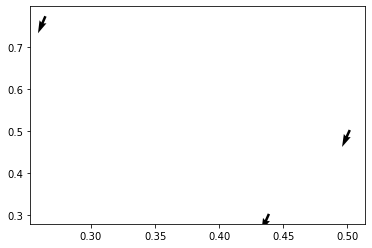

In [127]:
plot_swarm(swarm)

# Simulation

In [12]:
class Simulator:
    
    def __init__(self, v0, R, eta, max_step, init_action, step_action):
        self._v0 = v0
        self._R = R
        self._eta = eta
        self._max_step = max_step
        init_action(self)
        self._step_action = step_action
        
    def simulate(self, swarm):
        self._step_action(swarm, 0)
        for step in range(1, self._max_step + 1):
            swarm.move(self._v0, self._R, self._eta)
            self._step_action(swarm, step)

In [9]:
swarm = Swarm(100, 2)

In [13]:
simulator = Simulator(v0=0.1, R=0.2, eta =0.1, max_step=3, init_action=lambda x: None, step_action=plot_swarm)

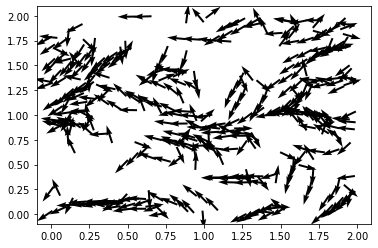

In [14]:
simulator.simulate(swarm)

# Animation

In [15]:
def init_animation(simulator):
    simulator._figure, simulator._axes = plt.subplots()
    def step_animation(i):
        swarm = simulator._swarm
        swarm.move(simulator._v0, simulator._R, simulator._eta)
        simulator._axes.quiver(swarm.x, swarm.y, np.cos(swarm.theta), np.sin(swarm.theta))
    simulator._step_animation = step_animation

In [ ]:
def step_animation_action(swarm, step):
    

In [50]:
class Animator(Simulator):
    
    def __init__(self, v0, R, eta, max_step):
        super().__init__(v0=v0, R=R, eta=eta, max_step=max_step,
                         init_action=lambda x: None, step_action=None)

    def simulate(self, swarm):
        self._figure, self._axes = plt.subplots()
        animation = FuncAnimation(self._figure, self._create_animate_func(swarm),
                                  init_func=self._create_init_func(swarm), frames=self._max_step)
        return HTML(animation.to_jshtml())

    def _create_init_func(self, swarm):
        def init_func():
            _ = self._axes.quiver(swarm.x, swarm.y, np.cos(swarm.theta), np.sin(swarm.theta))
        return init_func
    
    def _create_animate_func(self, swarm):
        def animate_func(i):
            swarm.move(self._v0, self._R, self._eta)
            plt.cla()
            _ = self._axes.quiver(swarm.x, swarm.y, np.cos(swarm.theta), np.sin(swarm.theta))
        return animate_func

In [51]:
animator = Animator(v0=0.1, R=0.2, eta =0.1, max_step=5)

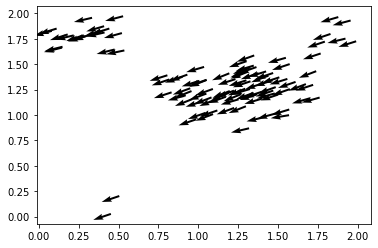

In [52]:
animator.simulate(swarm)